<a href="https://colab.research.google.com/github/bhanuteja2001/COVID-19-XrayDetection/blob/main/Model%20Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install split-folders

In [ ]:
"""import splitfolders
splitfolders.ratio(train_path, output="output", seed=1337, ratio=(.8, 0.1,0.1))"""

Copying files: 2919 files [23:58,  2.03 files/s]


In [ ]:
"""import shutil
shutil.move("/content/output", "/content/drive/MyDrive/covid_image_data")"""

'/content/drive/MyDrive/covid_image_data/output'

## VGG 16

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.optimizers import RMSprop
np.random.seed(1337)
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/covid_image_data/output/train'
valid_path = '/content/drive/MyDrive/covid_image_data/output/val'


vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

  
  # useful for getting number of classes
folders = glob('/content/drive/MyDrive/covid_image_data/output/train/*')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer=RMSprop(lr=0.0001),
  metrics=['accuracy']
)

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_checkpoint_every_epoch():
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    checkpoints_every_epoch = '/content/drive/MyDrive/covid_image_data/checkpoints_every_epoch/checkpoint_{epoch:03d}'
    checkpoint1 = ModelCheckpoint(filepath=checkpoints_every_epoch,
                             frequency='epoch',
                             save_weights_only=True,
                             verbose=1)
    checkpoint2 = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    
    return checkpoint1, checkpoint2

checkpoint_every_epoch = list(get_checkpoint_every_epoch())

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip = True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip = True,
                                   vertical_flip=True)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/covid_image_data/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/covid_image_data/output/val',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)


es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)'''





# fit the model
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  #steps_per_epoch=len(training_set),
  #validation_steps=len(test_set),

  callbacks=checkpoint_every_epoch
)




Found 2334 images belonging to 2 classes.
Found 291 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
146/146 [==============================] - ETA: 0s - loss: 0.4839 - accuracy: 0.7759
Epoch 00001: saving model to /content/drive/MyDrive/covid_image_data/checkpoints_every_epoch/checkpoint_001
146/146 [==============================] - 594s 4s/step - loss: 0.4839 - accuracy: 0.7759 - val_loss: 0.4095 - val_accuracy: 0.8110
Epoch 2/50
146/146 [==============================] - ETA: 0s - loss: 0.3816 - accuracy: 0.8440
Epoch 00002: saving model to /content/drive/MyDrive/covid_image_data/checkpoints_every_epoch/checkpoint_002
146/146 [==============================] - 65s 444ms/step - loss: 0.3816 - accuracy: 0.8440 - val_loss: 0.3643 - val_accuracy: 0.8419
Epoch 3/50
146/146 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8599
Epoch 00003: saving model to /content/drive/MyDrive/covid_image_data/ch

In [23]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/covid_image_data/output/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary',
                                            shuffle = False)
predictions = model.predict_generator(test_set, workers=0,verbose=0)
predictedClass = np.argmax(predictions, axis=1)
score = model.evaluate_generator(test_set, verbose=0)
print("loss: %.3f - acc: %.3f" % (score[0], score[1]))

loss: 0.296 - acc: 0.908


In [25]:
trueClass = test_set.classes[test_set.index_array]
classLabels = list(test_set.class_indices.keys())
from sklearn.metrics import confusion_matrix
confusionMatrix = (confusion_matrix(trueClass,predictedClass))
precision = (confusionMatrix[0][0])/(confusionMatrix[0][0] +confusionMatrix[1][0])
Recall = (confusionMatrix[0][0])/(confusionMatrix[0][0] +confusionMatrix[1][1])
F1 = (2*precision*Recall)/(precision+Recall)

In [31]:
print("F1 Score : ", (F1))
print("precision",precision)
print("recall",Recall)

F1 Score :  0.7558386411889596


In [20]:
result = model.evaluate(test_set, verbose=0)
print("Accuracy = ",result[1])
print("Loss = ",result[0])

Accuracy =  0.914675772190094
Loss =  0.28727567195892334


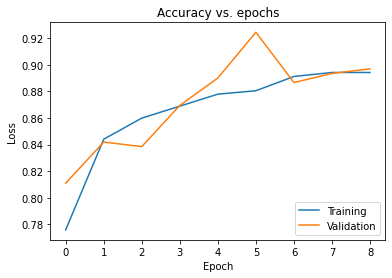

In [8]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

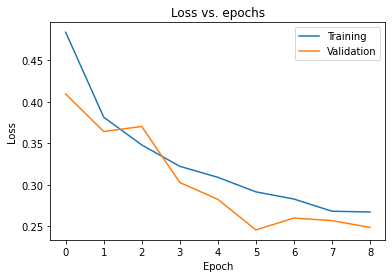

In [9]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

### ResNet 50

In [32]:
from keras.applications.resnet50 import ResNet50

In [33]:

from tensorflow.keras.optimizers import RMSprop
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/covid_image_data/output/train'
valid_path = '/content/drive/MyDrive/covid_image_data/output/val'


resn = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resn.layers:
    layer.trainable = False
  

  
  # useful for getting number of classes
folders = glob('/content/drive/MyDrive/covid_image_data/output/train/*')
  

# our layers - you can add more if you want
x = Flatten()(resn.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model1 = Model(inputs=resn.input, outputs=prediction)

# view the structure of the model
#model1.summary()

# tell the model what cost and optimization method to use
model1.compile(
  loss='binary_crossentropy',
  optimizer=RMSprop(lr=0.0001),
  metrics=['accuracy']
)

94773248/94765736 [==============================] - 0s 0us/step


In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_checkpoint_every_epoch():
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    checkpoints_every_epoch = '/content/drive/MyDrive/covid_image_data/checkpoints_every_epoch_resnet/checkpoint_{epoch:03d}'
    checkpoint1 = ModelCheckpoint(filepath=checkpoints_every_epoch,
                             frequency='epoch',
                             save_weights_only=True,
                             verbose=1)
    checkpoint2 = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    
    return checkpoint1, checkpoint2

checkpoint_every_epoch = list(get_checkpoint_every_epoch())

In [35]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip = True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip = True,
                                   vertical_flip=True)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/covid_image_data/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/covid_image_data/output/val',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

# fit the model
history = model1.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=checkpoint_every_epoch
)




Found 2334 images belonging to 2 classes.
Found 291 images belonging to 2 classes.
Epoch 1/50
146/146 [==============================] - ETA: 0s - loss: 0.5930 - accuracy: 0.6508
Epoch 00001: saving model to /content/drive/MyDrive/covid_image_data/checkpoints_every_epoch_resnet/checkpoint_001
146/146 [==============================] - 66s 450ms/step - loss: 0.5930 - accuracy: 0.6508 - val_loss: 0.4908 - val_accuracy: 0.8282
Epoch 2/50
146/146 [==============================] - ETA: 0s - loss: 0.4852 - accuracy: 0.7639
Epoch 00002: saving model to /content/drive/MyDrive/covid_image_data/checkpoints_every_epoch_resnet/checkpoint_002
146/146 [==============================] - 65s 444ms/step - loss: 0.4852 - accuracy: 0.7639 - val_loss: 0.4505 - val_accuracy: 0.8213
Epoch 3/50
146/146 [==============================] - ETA: 0s - loss: 0.4653 - accuracy: 0.7905
Epoch 00003: saving model to /content/drive/MyDrive/covid_image_data/checkpoints_every_epoch_resnet/checkpoint_003
146/146 [=======

In [36]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/covid_image_data/output/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary',
                                            shuffle = False)
predictions = model1.predict_generator(test_set, workers=0,verbose=0)
predictedClass = np.argmax(predictions, axis=1)
score = model1.evaluate_generator(test_set, verbose=0)
print("loss: %.3f - acc: %.3f" % (score[0], score[1]))

Found 293 images belonging to 2 classes.
loss: 0.435 - acc: 0.812


In [37]:
trueClass = test_set.classes[test_set.index_array]
classLabels = list(test_set.class_indices.keys())
confusionMatrix = (confusion_matrix(trueClass,predictedClass))
precision = (confusionMatrix[0][0])/(confusionMatrix[0][0] +confusionMatrix[1][0])
Recall = (confusionMatrix[0][0])/(confusionMatrix[0][0] +confusionMatrix[1][1])
F1 = (2*precision*Recall)/(precision+Recall)

In [38]:
print("F1 Score : ", (F1))
print("precision",precision)
print("recall",Recall)

F1 Score :  0.7558386411889596
precision 0.6075085324232082
recall 1.0


In [39]:
result = model1.evaluate(test_set, verbose=0)
print("Accuracy = ",result[1])
print("Loss = ",result[0])

Accuracy =  0.8259385824203491
Loss =  0.42132681608200073


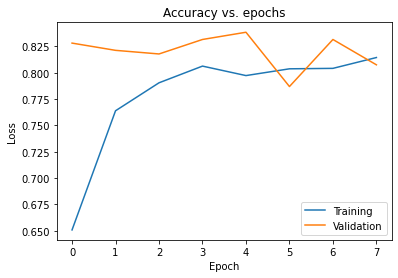

In [41]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

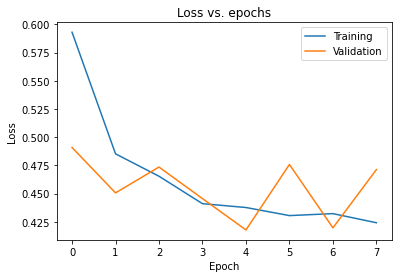

In [40]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

##### EVALUATE GENERATOR
[Keras: how to evaluate model accuracy (evaluate_generator vs. predict_generator)?](https://stackoverflow.com/questions/55868975/keras-how-to-evaluate-model-accuracy-evaluate-generator-vs-predict-generator)

### VGG 19

In [42]:
from keras.applications.vgg19 import VGG19

In [43]:
#from tensorflow.keras.optimizers import RMSprop
np.random.seed(1337)
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/covid_image_data/output/train'
valid_path = '/content/drive/MyDrive/covid_image_data/output/val'


vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg19.layers:
  layer.trainable = False
  

  
  # useful for getting number of classes
folders = glob('/content/drive/MyDrive/covid_image_data/output/train/*')
  

# our layers - you can add more if you want
x = Flatten()(vgg19.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model3 = Model(inputs=vgg19.input, outputs=prediction)

# view the structure of the model
model3.summary()

# tell the model what cost and optimization method to use
model3.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=0.0001),
    metrics=['accuracy']
)

80142336/80134624 [==============================] - 1s 0us/step
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_checkpoint_every_epoch():
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    checkpoints_every_epoch = '/content/drive/MyDrive/covid_image_data/checkpoints_every_epoch_vgg19/checkpoint_{epoch:03d}'
    checkpoint1 = ModelCheckpoint(filepath=checkpoints_every_epoch,
                             frequency='epoch',
                             save_weights_only=True,
                             verbose=1)
    checkpoint2 = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    
    return checkpoint1, checkpoint2

checkpoint_every_epoch = list(get_checkpoint_every_epoch())

In [45]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip = True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip = True,
                                   vertical_flip=True)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/covid_image_data/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'binary'
                                                 )

val_set = test_datagen.flow_from_directory('/content/drive/MyDrive/covid_image_data/output/val',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary'
                                            )

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)


es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, 
                                               restore_best_weights=True,
                                               verbose=1)'''





# fit the model
history = model3.fit_generator(
  training_set,
  validation_data=val_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set),
  callbacks=checkpoint_every_epoch
)




Found 2334 images belonging to 2 classes.
Found 291 images belonging to 2 classes.
Epoch 1/50
146/146 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.7853
Epoch 00001: saving model to /content/drive/MyDrive/covid_image_data/checkpoints_every_epoch_vgg19/checkpoint_001
146/146 [==============================] - 66s 450ms/step - loss: 0.4738 - accuracy: 0.7853 - val_loss: 0.4113 - val_accuracy: 0.8110
Epoch 2/50
146/146 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8363
Epoch 00002: saving model to /content/drive/MyDrive/covid_image_data/checkpoints_every_epoch_vgg19/checkpoint_002
146/146 [==============================] - 65s 446ms/step - loss: 0.3954 - accuracy: 0.8363 - val_loss: 0.3719 - val_accuracy: 0.8419
Epoch 3/50
146/146 [==============================] - ETA: 0s - loss: 0.3623 - accuracy: 0.8505
Epoch 00003: saving model to /content/drive/MyDrive/covid_image_data/checkpoints_every_epoch_vgg19/checkpoint_003
146/146 [==========

In [46]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/covid_image_data/output/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'binary',
                                            shuffle = False)
predictions = model3.predict_generator(test_set, workers=0,verbose=0)
predictedClass = np.argmax(predictions, axis=1)
score = model3.evaluate_generator(test_set, verbose=0)
print("loss: %.3f - acc: %.3f" % (score[0], score[1]))

Found 293 images belonging to 2 classes.
loss: 0.281 - acc: 0.908


In [47]:
trueClass = test_set.classes[test_set.index_array]
classLabels = list(test_set.class_indices.keys())
from sklearn.metrics import confusion_matrix
confusionMatrix = (confusion_matrix(trueClass,predictedClass))
precision = (confusionMatrix[0][0])/(confusionMatrix[0][0] +confusionMatrix[1][0])
Recall = (confusionMatrix[0][0])/(confusionMatrix[0][0] +confusionMatrix[1][1])
F1 = (2*precision*Recall)/(precision+Recall)

In [48]:
print("F1 Score : ", (F1))
print("precision",precision)
print("recall",Recall)

F1 Score :  0.7558386411889596
precision 0.6075085324232082
recall 1.0


In [49]:
result = model3.evaluate(test_set, verbose=0)
print("Accuracy = ",result[1])
print("Loss = ",result[0])

Accuracy =  0.8907849788665771
Loss =  0.28610700368881226


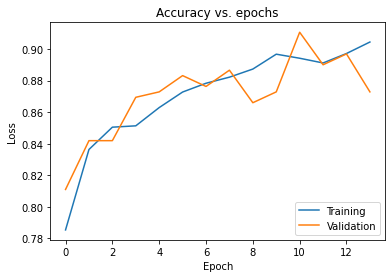

In [50]:
try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
except KeyError:
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

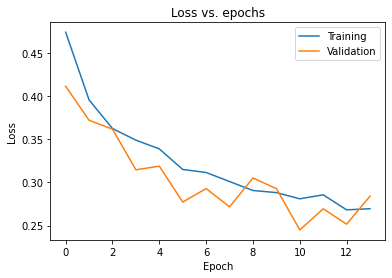

In [51]:
#Run this cell to plot the epoch vs loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

## Testing

In [ ]:
df_testing = pd.read_csv('/content/drive/MyDrive/covid_image_data/Testing_set_covid.csv')
df_testing.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [ ]:
images_testing = [[fname, '/content/drive/MyDrive/covid_image_data/test/' + fname[:-4] + '.jpg'] for fname in df_testing['filename']]
images_testing = pd.DataFrame(images_testing)
images_testing.columns = ['filename', 'file']
images_testing

,filename,file
0,Image_1.jpg,/content/drive/MyDrive/covid_image_data/test/I...
1,Image_2.jpg,/content/drive/MyDrive/covid_image_data/test/I...
2,Image_3.jpg,/content/drive/MyDrive/covid_image_data/test/I...
3,Image_4.jpg,/content/drive/MyDrive/covid_image_data/test/I...
4,Image_5.jpg,/content/drive/MyDrive/covid_image_data/test/I...
...,...,...
865,Image_866.jpg,/content/drive/MyDrive/covid_image_data/test/I...
866,Image_867.jpg,/content/drive/MyDrive/covid_image_data/test/I...
867,Image_868.jpg,/content/drive/MyDrive/covid_image_data/test/I...
868,Image_869.jpg,/content/drive/MyDrive/covid_image_data/test/I...


In [ ]:
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
test_image = []
for i in tqdm(range(images_testing.shape[0])):
    img = load_img(images_testing['file'][i], target_size=(224, 224, 3), grayscale=False)
    img = img_to_array(img)
    img = img/255
    test_image.append(img)
X = np.array(test_image)

100%|██████████| 870/870 [07:16<00:00,  1.99it/s]


In [ ]:
prediction = model.predict(X)

In [ ]:
K = pd.DataFrame(prediction)

In [ ]:
K.head()

,0
0,0.075002
1,0.006712
2,0.975476
3,0.047779
4,0.752774


In [ ]:
L = []
for i in range(len(K[0])):
  if K[0][i] > 0.5:
    L.append(1)
  else:
    L.append(0) 

In [ ]:
# To download the csv file locally
from google.colab import files
res = pd.DataFrame(L) 
res.columns = ["prediction"]
res.to_csv('prediction_results_vgg19.csv',index=False)         
files.download('prediction_results_vgg19.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>